# Test of Miovision Data Completeness With Cadence

In the `pull_data` function in `intersection_tmc.py`, data is retrieved using the Miovision API with a cadence given by `time_delta`. Recently Aakash and Raph [discovered](https://github.com/CityofToronto/bdit_data-sources/issues/323#issuecomment-681085745) that if this cadence were set too large, the Miovision server would return incomplete data. In this notebook, we check for the largest cadence that returns complete data.

In [75]:
import requests
from requests import exceptions
import pytz
from datetime import timedelta, datetime
import math
import time
import json
import pathlib
import configparser
import numpy as np
import pandas as pd
import missingno as msno

In [2]:
config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath('.charlesconfig').as_posix());
miov_token = config['MIOVISION']['key']

local_tz = pytz.timezone('US/Eastern')
url='https://api.miovision.com/intersections/' 
tmc_endpoint = '/tmc'

In [150]:
class MiovisionAPIException(Exception):
    """Base class for exceptions."""
    pass
  

class TimeoutException(Exception):
    """Exception if API gives a 504 error"""
    pass
    

class NotFoundError(Exception):
    """Exception for a 404 error."""
    pass


def poll_miovision_api(start_time, end_time,
                       intersection_id='6174c193-13a9-4056-832b-f80783eaf333'):

    headers = {'Content-Type':'application/json', 'Authorization': miov_token} 
    params = {'endTime': end_time, 'startTime' : start_time}

    response = requests.get(url + intersection_id + tmc_endpoint,
                            params=params, headers=headers)

    if response.status_code == 200:
        tmc = json.loads(response.content.decode('utf-8'))
        if len(tmc) == 0:
            raise ValueError("Successfully returned nothing...")
        tmc = pd.DataFrame(tmc)
        # [tmc['class'] == "Light"]
        tmc_counts = (tmc.loc[:]
                      .groupby("timestamp")['timestamp'].count().sort_index())
        tmc_counts.index = pd.to_datetime(tmc_counts.index)
        return tmc_counts
    elif response.status_code == 404:
        error = json.loads(response.content.decode('utf-8'))
        raise NotFoundError(error['error'])
    elif response.status_code == 400:
        error=json.loads(response.content.decode('utf-8'))
        raise MiovisionAPIException(error['error'])
    elif response.status_code == 504:
        raise TimeoutException('Error'+str(response.status_code))

## Reproduce Raph's Comment

Reproduce Raph's comment [here](https://github.com/CityofToronto/bdit_data-sources/issues/323#issuecomment-681085745).

In [57]:
start_time = local_tz.localize(datetime(2020, 8, 20))
end_time = local_tz.localize(datetime(2020, 8, 21, 1))

tlc_full_day = poll_miovision_api(start_time, end_time)

In [58]:
tlc_full_day[tlc_full_day.index > pd.Timestamp("2020-08-20 17:00:00", tz=local_tz)]

Series([], Name: timestamp, dtype: int64)

In [16]:
start_time = local_tz.localize(datetime(2020, 8, 20, 17))
end_time = local_tz.localize(datetime(2020, 8, 21, 1))

tlc_evening_only = poll_miovision_api(start_time, end_time)

In [17]:
tlc_evening_only.sum()

4500

This is the same number of rows Raph reports.

## Check Data Completeness with Cadence

Now we find the largest cadence that returns all available data in the day.

In [161]:
def timerange(start_time, end_time, dt):
    for i in range(math.ceil((end_time - start_time) / dt)):
        c_start = start_time + i * dt
        yield (c_start, c_start + dt)


def compare_cadences(start_time, end_time, dt_range,
                     intersection_id='6174c193-13a9-4056-832b-f80783eaf333',
                     retry_times=3):

    df = pd.DataFrame(index=pd.date_range(start_time, end_time, freq="60 s")[:-1])

    for cdtval in dt_range:
        cdt = timedelta(hours=cdtval)
        
        joined_data = []
        for (c_start, c_end) in timerange(start_time, end_time, cdt):
            for i in range(retry_times):
                cjd = None
                try:
                    cjd = poll_miovision_api(c_start, c_end,
                                             intersection_id=intersection_id)
                except exceptions.ProxyError as prox:
                    print("ProxyError; retrying in 2 minutes")
                    time.sleep(120)
                except exceptions.RequestException as err:
                    print("RequestException; retrying in 1:15 minutes")
                    time.sleep(75)
                except NotFoundError:
                    break
                except TimeoutException as exc_504:
                    print(exc_504)
                    sleep(60)
                except MiovisionAPIException as miovision_exc:
                    print(miovision_exc)
                    break
                else:
                    break
        
            if cjd is None:
                raise ValueError("API didn't return anything.")
            joined_data.append(cjd)
                
        joined_data = pd.concat(joined_data)

        df[int(cdtval)] = joined_data
    
    return df.sort_index()

In [66]:
start_time = local_tz.localize(datetime(2020, 8, 20))
end_time = local_tz.localize(datetime(2020, 8, 24))
dt_range = [4., 6., 12., 24., 48.]

df_cc = compare_cadences(start_time, end_time, dt_range)

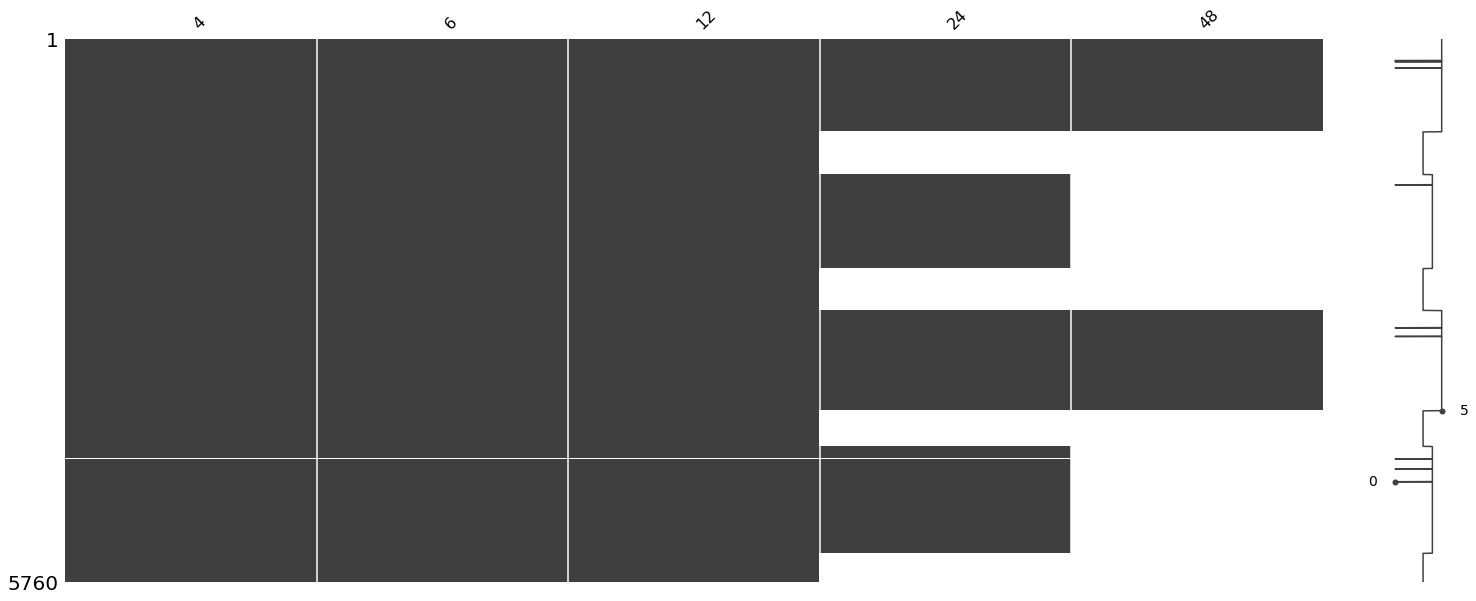

In [78]:
msno.matrix(df_cc)

We have substantial data gaps when using a cadence of 24 hours or more. It appears that only the first ~950 or so data points are returned (this changes from block to block).

In [79]:
df_cc.sort_index().loc[df_cc[4].isna(), 4]

2020-08-20 03:52:00-04:00   NaN
2020-08-20 04:03:00-04:00   NaN
2020-08-20 05:09:00-04:00   NaN
2020-08-21 01:48:00-04:00   NaN
2020-08-22 03:02:00-04:00   NaN
2020-08-22 04:34:00-04:00   NaN
2020-08-23 02:12:00-04:00   NaN
2020-08-23 04:00:00-04:00   NaN
2020-08-23 06:13:00-04:00   NaN
Name: 4, dtype: float64

Even in the case of 4 hour cadence there is missing data, but these are isolated minutes in the middle of the night, so are probably just minutes where no vehicles were detected.

We see the same pattern on another day.

In [84]:
start_time = local_tz.localize(datetime(2020, 7, 15))
end_time = local_tz.localize(datetime(2020, 7, 19))
dt_range = [4., 6., 12., 24., 48.]

df_cc = compare_cadences(start_time, end_time, dt_range)

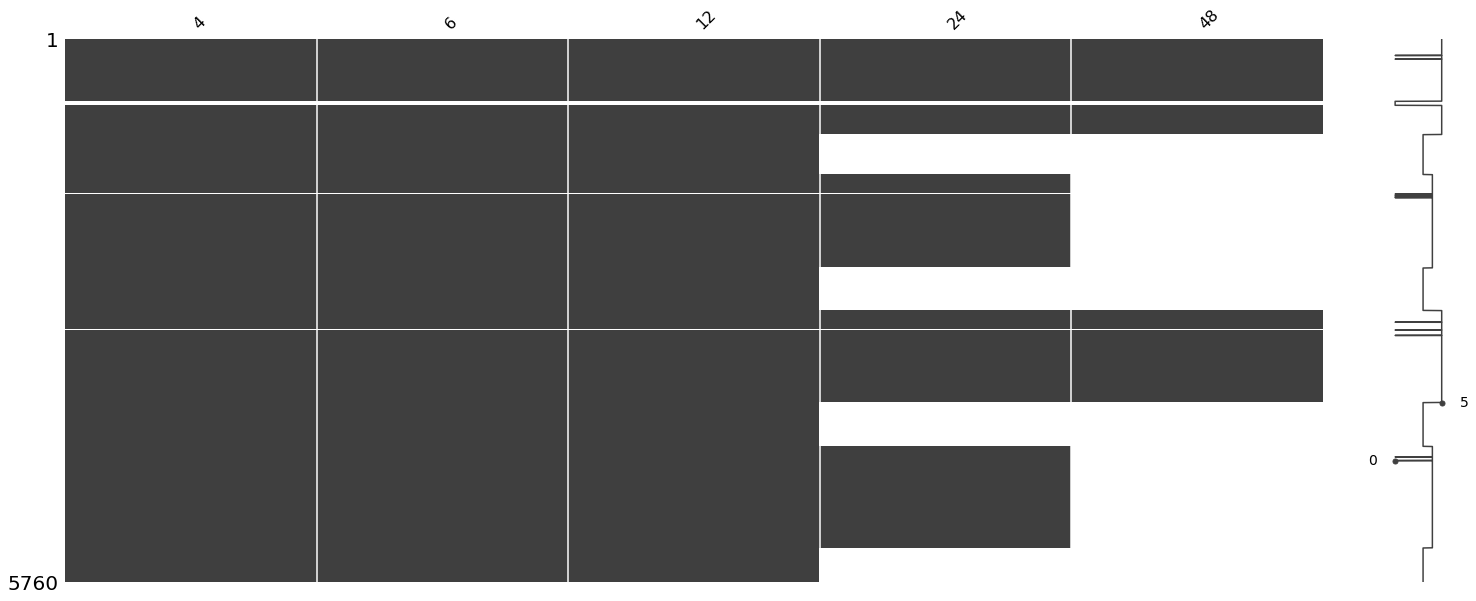

In [88]:
msno.matrix(df_cc)

Though this day has an extended period of time when there were no vehicles, perhaps indicating a camera failure.

In [89]:
df_cc.sort_index().loc[df_cc[4].isna(), 4]

2020-07-15 02:57:00-04:00   NaN
2020-07-15 03:36:00-04:00   NaN
2020-07-15 11:03:00-04:00   NaN
2020-07-15 11:04:00-04:00   NaN
2020-07-15 11:05:00-04:00   NaN
2020-07-15 11:06:00-04:00   NaN
2020-07-15 11:07:00-04:00   NaN
2020-07-15 11:08:00-04:00   NaN
2020-07-15 11:09:00-04:00   NaN
2020-07-15 11:10:00-04:00   NaN
2020-07-15 11:11:00-04:00   NaN
2020-07-15 11:12:00-04:00   NaN
2020-07-15 11:13:00-04:00   NaN
2020-07-15 11:14:00-04:00   NaN
2020-07-15 11:15:00-04:00   NaN
2020-07-15 11:16:00-04:00   NaN
2020-07-15 11:17:00-04:00   NaN
2020-07-15 11:18:00-04:00   NaN
2020-07-15 11:19:00-04:00   NaN
2020-07-15 11:20:00-04:00   NaN
2020-07-15 11:21:00-04:00   NaN
2020-07-15 11:22:00-04:00   NaN
2020-07-15 11:23:00-04:00   NaN
2020-07-15 11:24:00-04:00   NaN
2020-07-15 11:25:00-04:00   NaN
2020-07-15 11:26:00-04:00   NaN
2020-07-15 11:27:00-04:00   NaN
2020-07-15 11:28:00-04:00   NaN
2020-07-15 11:29:00-04:00   NaN
2020-07-15 11:30:00-04:00   NaN
2020-07-15 11:31:00-04:00   NaN
2020-07-

In [114]:
df_cc.iloc[1016, :]

4     15.0
6     15.0
12    15.0
24     NaN
48     NaN
Name: 2020-07-15 16:56:00-04:00, dtype: float64

Looking at another station, we see the same thing:

In [136]:
start_time = local_tz.localize(datetime(2020, 7, 15))
end_time = local_tz.localize(datetime(2020, 7, 19))
dt_range = [4., 6., 12., 24., 48.]

df_cc = compare_cadences(start_time, end_time, dt_range, intersection_id="169471e1-c460-489a-9765-352c0803990b")

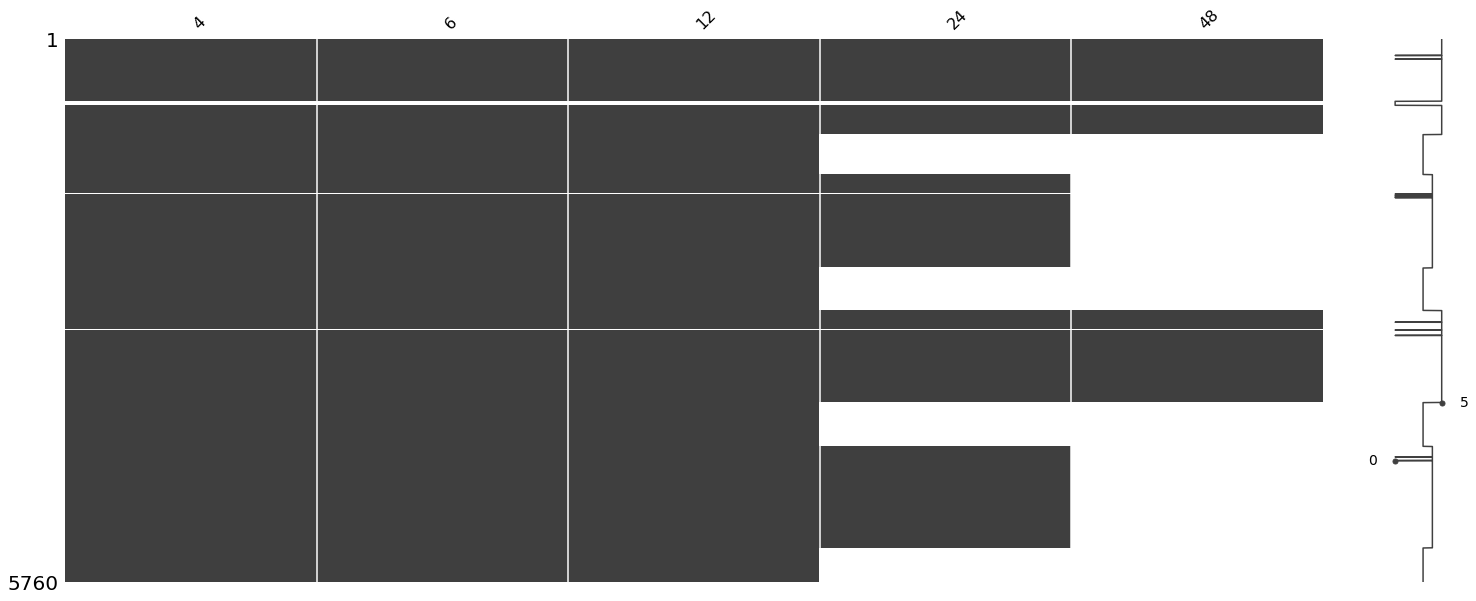

In [137]:
msno.matrix(df_cc)

Another station at another time of year:

In [162]:
start_time = local_tz.localize(datetime(2019, 12, 3))
end_time = local_tz.localize(datetime(2019, 12, 7))
dt_range = [4., 6., 12., 24., 48.]

df_cc = compare_cadences(start_time, end_time, dt_range, intersection_id="151ee827-dd49-4ad4-af21-dde5d7032c21")

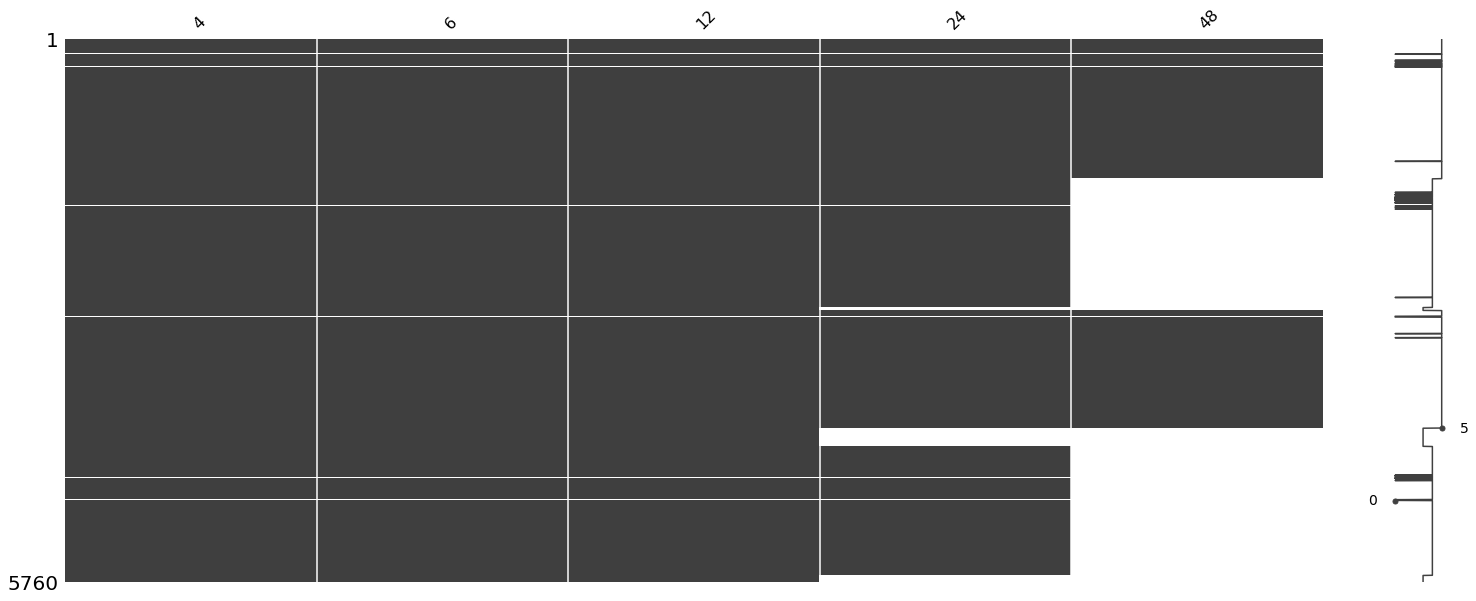

In [163]:
msno.matrix(df_cc)

And yet another.

In [164]:
start_time = local_tz.localize(datetime(2019, 5, 25))
end_time = local_tz.localize(datetime(2019, 5, 29))
dt_range = [4., 6., 12., 24., 48.]

df_cc = compare_cadences(start_time, end_time, dt_range, intersection_id="02a90c2e-b428-4f89-9422-327c8c91671d")

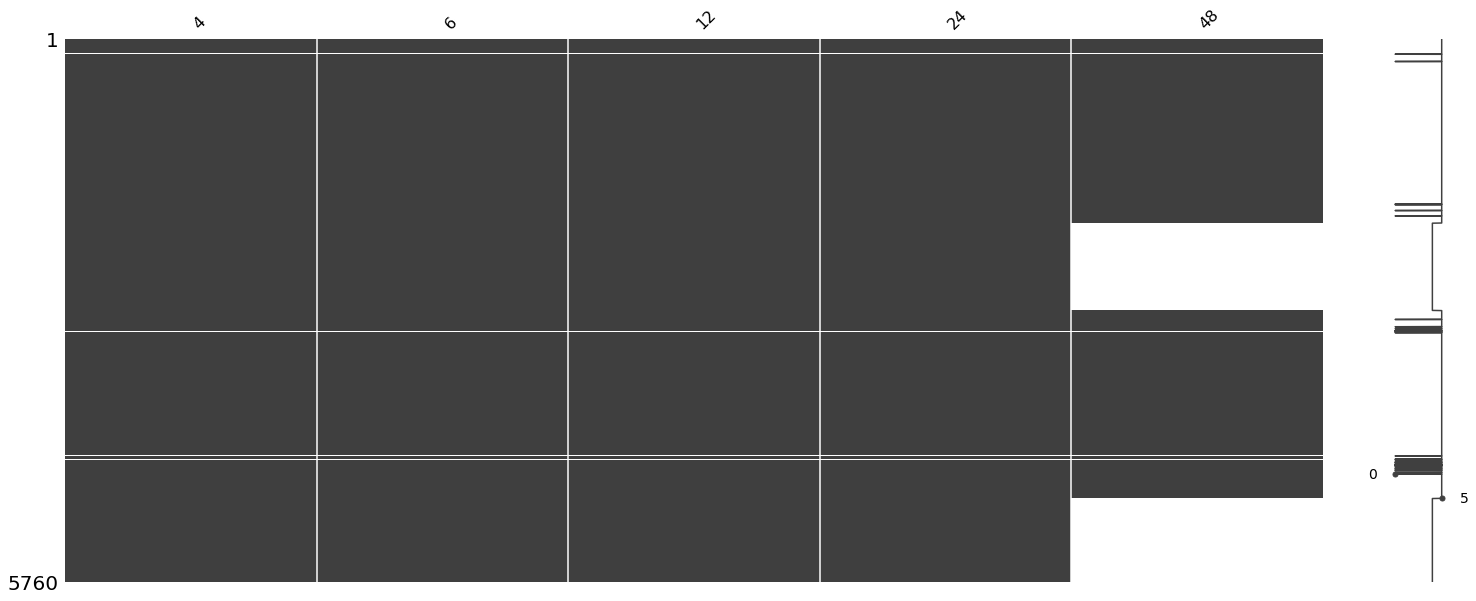

In [165]:
msno.matrix(df_cc)

So it looks like picking any cadence of 12 hours or less will return all available data, though we'll need to test this hypothesis at scale.